# 0. Start

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import importlib
import pandas as pd
import copy

In [33]:
def normalization(data):
    # _range = np.max(data) - np.min(data)
    # return (data - np.min(data)) / _range
    return data / np.max(data)

# S1. load and pre-process raw data

the raw data is extracted from paper <**Which parts of the road guide obstacle avoidance? Quantifying the driver's risk field**>

data link: https://data.4tu.nl/articles/dataset/Driver_s_Risk_Fields_DRF_-_Simulator_Experiment/12707702/1

by modifying the code: <*DRF_data_R2\DRF_data_R1\AnalysisCode\Data_extraction.m*> (see save_csv.m), we obtain the necessary data and save them into csv files.

#### 1.1 load raw data

In [3]:
objective_data = {}
subjective_data = {}
heading_data, position_data = {}, {}
for i in range(8):
    Angles = pd.read_csv(r'data\angle_P' + str(i+1) + '.csv', names=range(312))
    response = pd.read_csv(r'data\sub_resp_P' + str(i+1) + '.csv', names=range(78))
    objective_data[i] = np.array(Angles)
    subjective_data[i] = np.array(response).reshape(78,)
LDs = pd.read_csv(r'data\LDs.csv', names=range(312)).to_numpy()
ObjX = pd.read_csv(r'data\Obsoffx.csv', names=range(78)).to_numpy()[0]
ObjY = pd.read_csv(r'data\Obsoffy.csv', names=range(78)).to_numpy()[0]
# print(LDs.shape, Angles.shape, ObjX.shape, ObjY.shape)

data structure:

objective_data:
- rows: time [second]
- columns: steering angle for each obstacle. 4 (trials for one obstacles) * 77
  - there are four more columns when we get the raw data according to the matlab codes, we do not know why and use the similar way to obtain data relative to every obstacle

subjective data:
- response number of each obstacle

#### 1.2 select and norm the data

use data in the first 1 second (0-25 rows), and delete data that steering angle < 2 degree

In [4]:
norm_objective_data = []  # norm the data in to [0,1]
obj_data_raw = []
norm_subjective_data = []
sub_data_raw = []
max_values = [[],[]]  # maximum value of each driver
use_lines = 25
for subID in range(8):
    objective_data[subID][np.abs(objective_data[subID]) <= 2] = 0
    obj_dataset = []
    for objID in range(77):
        st_angle = np.mean(np.max(np.abs(objective_data[subID][:use_lines,4*objID:4*objID+4]), 0))
        st_angle = 0 if st_angle <2 else st_angle
        obj_dataset.append(st_angle)
    
    tmp = normalization(obj_dataset)

    obj_data_raw.append(copy.deepcopy(obj_dataset))
    norm_objective_data.append(tmp)

    norm_subjective_data.append(normalization(subjective_data[subID]))
    sub_data_raw.append(subjective_data[subID])

    max_values[0].append(np.max(obj_dataset))
    max_values[1].append(np.max(subjective_data[subID]))

In [5]:
# for objective signals, all the drivers' data are normed in to [0,1] for comparison
scale_norm_objective_data = []
max_angle = np.array(max_values[0]).max()
scales = np.array(max_values[0]) / max_angle
for i in range(8):
    scale_norm_objective_data.append(np.array(norm_objective_data[i]) * scales[i])

In [6]:
# save data for drawing pictures
with open(r'data\data_for_drawing.pkl', 'wb') as f:
    saved_ = dict(obj_data_raw=obj_data_raw, norm_objective_data=norm_objective_data, sub_data_raw=sub_data_raw, norm_subjective_data=norm_subjective_data, max_values=max_values)
    pickle.dump(saved_, f)

#### 1.3 calculate the necessary information needed for calibration, including the predicted trajectories, relative distances, damages etc.

In [8]:
import podar_process

In [16]:
importlib.reload(podar_process)

pred_hori = 7

dataset = []
podar = []
podar_max = []
for subID in range(8):
    A = A_list[subID]
    B = B_list[subID]
    Alpha = Alpha_list[subID]

    sub_dataset = []
    podar_i = []
    for objID in range(77):
        x_obj, y_obj = ObjX[objID], ObjY[objID]
        vehicles_1 = podar_process.Vehicles()
        vehicles_1.set_ego(type='car', x0=0, y0=0, speed=25, phi0=0)
        vehicles_1.add_obj(type='car', x0=x_obj, y0=-y_obj, speed=0, phi0=np.pi, length=15, width=0.25)
        podar_process.step(vehicles_1, pred_hori=pred_hori) #,pred_hori=pred_hori

        resp = norm_subjective_data[subID][objID]
        resp_raw = sub_data_raw[subID][objID]

        st_angle = scale_norm_objective_data[subID][objID]  # norm_objective_data[subID][objID]
        st_angle_raw= obj_data_raw[subID][objID]

        sub_dataset.append(dict(objid=objID, subid=subID,
                                delta_v=torch.tensor(vehicles_1.obj[0].delta_v),
                                abs_v=torch.tensor(vehicles_1.obj[0].abs_v),
                                i=torch.tensor(vehicles_1.obj[0].time_t),
                                d=torch.tensor(vehicles_1.obj[0].dis_t),
                                response=torch.tensor([resp]),
                                response_raw=torch.tensor([resp_raw]),
                                st_angle=torch.tensor([st_angle]),
                                st_angle_raw=torch.tensor([st_angle_raw])))
        # print('--', subID, objID, '\t|  ', x_obj, y_obj, '\t|  ', vehicles_1.obj[0].risk, '\t|  ', sub_data_raw[subID][objID], '\t|  ', obj_data_raw[subID][objID])
    dataset.append(sub_dataset)

In [17]:
# save data
with open(r'data\dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

#### 1.3 determine the peak numbers

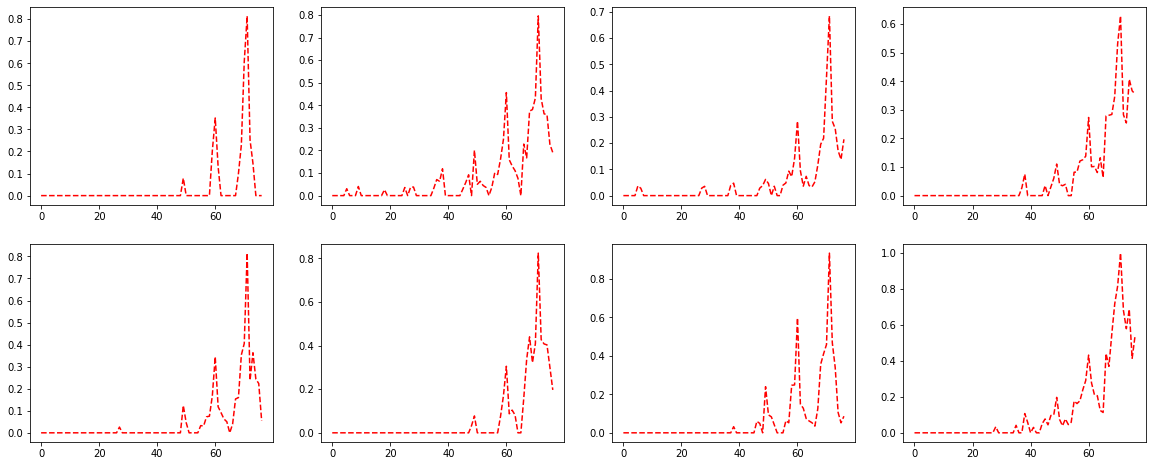

In [20]:
# objective data
plt.figure(figsize=(20, 8))
for sid in range(8):
    plt.subplot(240 + sid+1)
    # r = norm_subjective_data[sid]
    r = scale_norm_objective_data[sid]
    plt.plot(r, linestyle='--', c='r', label='angle')

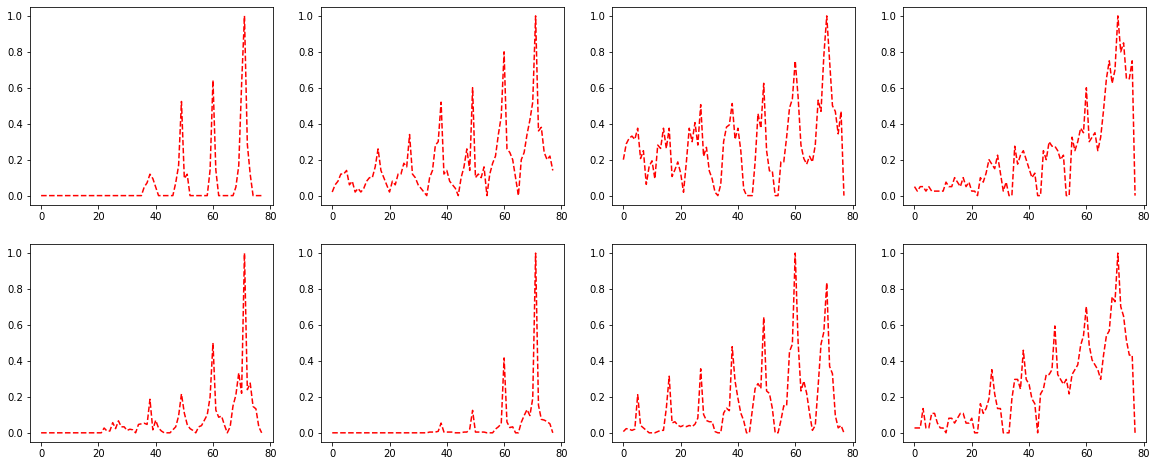

In [21]:
# subjective data
plt.figure(figsize=(20, 8))
for sid in range(8):
    plt.subplot(240 + sid+1)
    r = norm_subjective_data[sid]
    # r = scale_norm_objective_data[sid]
    plt.plot(r, linestyle='--', c='r', label='angle')

determined_horizon_results:

peak_num_angle = [3, 7, 5, 4, 3, 3, 4, 5]

peak_num_respons = [4, 7, 7, 6, 5, 4, 7, 7]

# S2. PODAR calibration

#### 2.1 torch net

In [15]:
import calibration_net

#### 2.2 train

##### objective signals

=====subject ID = 0, type: obj
ite_num: 10000, loss: 0.0014332091668620706, parameters A: 1.060044288635254, B: 3.7158215045928955, alpha: 0.699999988079071, scale: 1.6150931119918823, p_max: 0.8651466965675354
ite_num: 20000, loss: 0.0014332092832773924, parameters A: 1.060044288635254, B: 3.7158215045928955, alpha: 0.699999988079071, scale: 1.6150931119918823, p_max: 0.8651466965675354
ite_num: 30000, loss: 0.0014332092832773924, parameters A: 1.060044288635254, B: 3.7158215045928955, alpha: 0.699999988079071, scale: 1.6150931119918823, p_max: 0.8651466965675354
ite_num: 40000, loss: 0.0014332092832773924, parameters A: 1.060044288635254, B: 3.7158215045928955, alpha: 0.699999988079071, scale: 1.6150931119918823, p_max: 0.8651466965675354
ite_num: 50000, loss: 0.0014332092832773924, parameters A: 1.060044288635254, B: 3.7158215045928955, alpha: 0.699999988079071, scale: 1.6150931119918823, p_max: 0.8651466965675354
---final parameters A: 1.060044288635254, B: 3.7158215045928955, alph

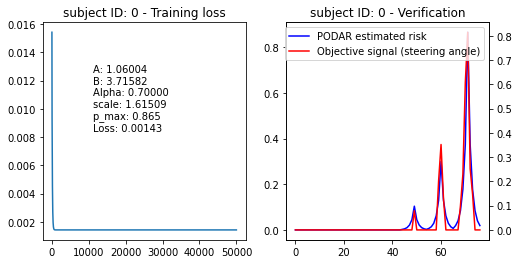

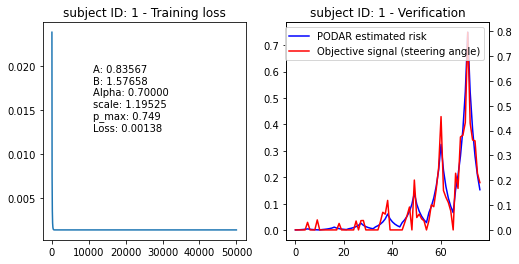

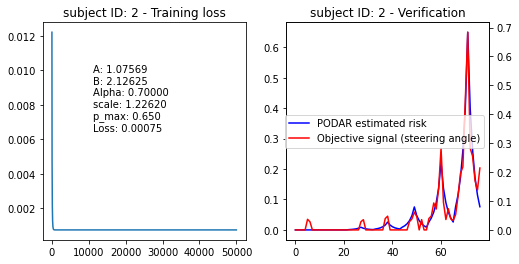

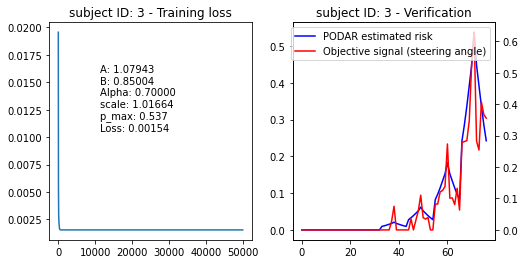

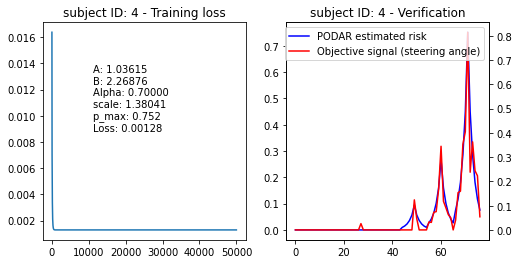

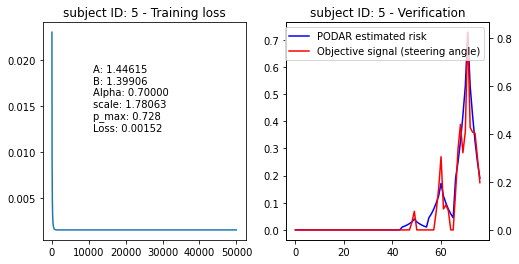

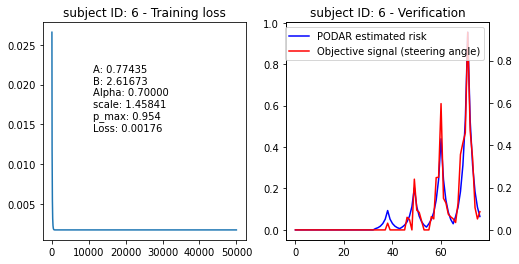

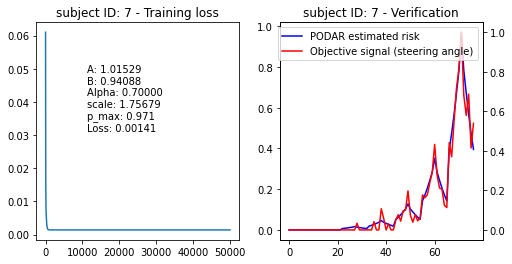

In [36]:
A_list, B_list, p_max_list, scale_list = [], [], [], []
plt.ioff()
for subID in range(8): #range(2)
    a, b, p, s = calibration_net.train(subID, type='obj')  # 
    A_list.append(a)
    B_list.append(b)
    p_max_list.append(p)
    scale_list.append(s)
print(A_list, B_list, p_max_list, scale_list)

train results

In [43]:
A_list = [1.0600444078445435, 0.8356727361679077, 1.0756944417953491, 1.0794345140457153, 1.036150336265564, 1.4461475610733032, 0.7743525505065918, 1.0152881145477295]
B_list = [3.715822219848633, 1.576579213142395, 2.126253843307495, 0.8500350117683411, 2.26875638961792, 1.3990570306777954, 2.6167290210723877, 0.9408774971961975]
scale_list = [1.6150935888290405, 1.195246934890747, 1.2262033224105835, 1.016636848449707, 1.380411148071289, 1.7806282043457031, 1.4584137201309204, 1.7567945718765259]
horizon_list = [4, 7, 7, 6, 5, 4, 7, 7]

##### subjective signals

=====subject ID = 0, type: sub
---final parameters A: 0.5059424638748169, B: 4.7648186683654785, alpha: 0.699999988079071, scale: 1.3329046964645386, p_max: 1.052304983139038
=====subject ID = 1, type: sub
---final parameters A: 0.27508944272994995, B: 2.1246397495269775, alpha: 0.699999988079071, scale: 0.985039472579956, p_max: 0.9140646457672119
=====subject ID = 2, type: sub
---final parameters A: 0.0, B: 1.3701989650726318, alpha: 0.699999988079071, scale: 0.5091432332992554, p_max: 0.5727856755256653
=====subject ID = 3, type: sub
---final parameters A: 0.5848498940467834, B: 0.5749659538269043, alpha: 0.699999988079071, scale: 1.2405551671981812, p_max: 0.9267663955688477
=====subject ID = 4, type: sub
---final parameters A: 0.6546937227249146, B: 3.5374865531921387, alpha: 0.699999988079071, scale: 1.2741222381591797, p_max: 0.906425952911377
=====subject ID = 5, type: sub
---final parameters A: 0.9557045698165894, B: 7.115492820739746, alpha: 0.699999988079071, scale: 1.735061

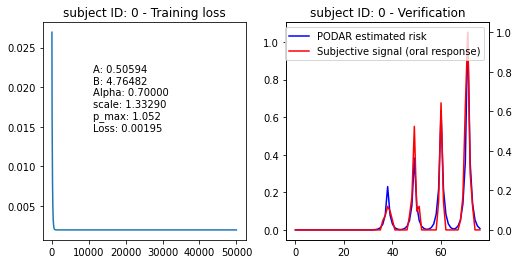

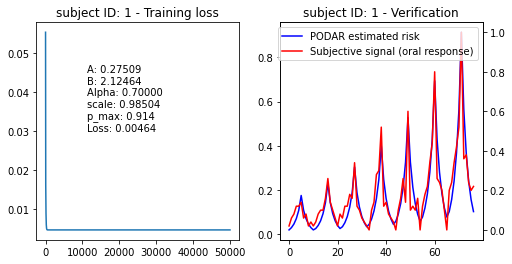

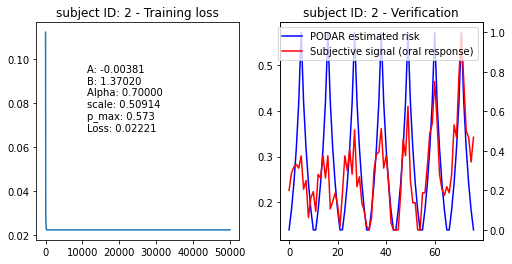

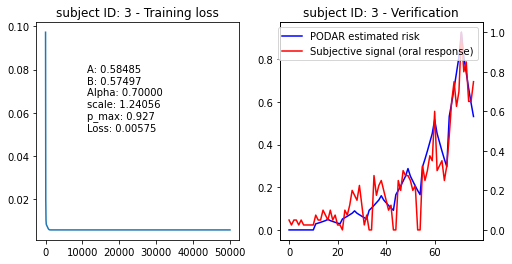

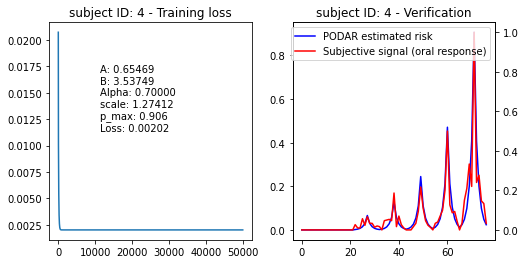

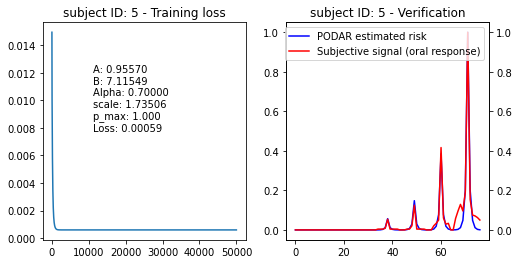

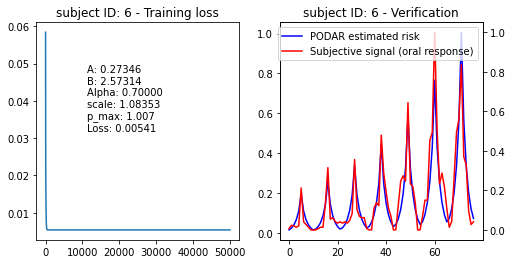

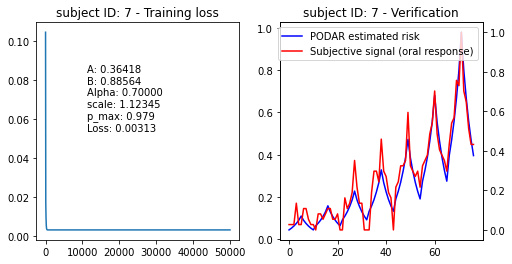

In [45]:
A_list, B_list, p_max_list, scale_list = [], [], [], []
plt.ioff()
for subID in range(8):
    a, b, p, s = calibration_net.train(subID, type='sub')  # 
    A_list.append(a)
    B_list.append(b)
    p_max_list.append(p)
    scale_list.append(s)
print(A_list, B_list, p_max_list, scale_list)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

There are an un-normal situation in participant P3 (ID=2) that the net can not learn a reasonable parameter A. 

Here, we make a clip to parameter A by modifying the Line 56: self.A_ = torch.clamp(self.A, 0.0, 50)  -> self.A_ = torch.clamp(self.A, 0.17, 50) to test the net performance.

The reason why choosing 0.17 is based on several manual adjustment between [0.1, 0.25] with interval of 0.01, and we found that when let A=0.17, the net will get the minimal loss. 

We do not know why, but you can see that it will have a better fitness when using A=0.17 than the learned A=0.0.

(A's value display in the the following cell pictures are the raw value of A before clip, the actual value that calculate the risk is 0.17 after clipping)

In [65]:
importlib.reload(calibration_net)

<module 'calibration_net' from 'e:\\博后工作资料\\01_研究工作\\99_codes\\Archive\\PODAR_calibration\\calibration_net.py'>

=====subject ID = 2, type: sub
---final parameters A: 0.17000000178813934, B: 1.4296964406967163, alpha: 0.699999988079071, scale: 0.9143654108047485, p_max: 0.9132525324821472
[0.17000000178813934] [1.4296964406967163] [0.9132525324821472] [0.9143654108047485]


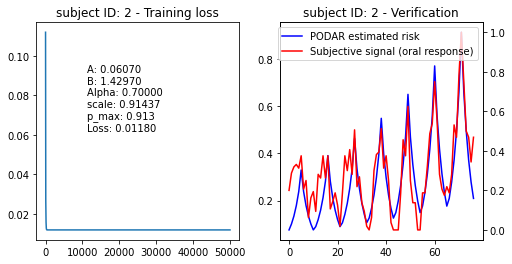

In [66]:
A_list, B_list, p_max_list, scale_list = [], [], [], []
plt.ioff()
for subID in [2]:
    a, b, p, s = calibration_net.train(subID, type='sub')  # 
    A_list.append(a)
    B_list.append(b)
    p_max_list.append(p)
    scale_list.append(s)
print(A_list, B_list, p_max_list, scale_list)

train results

In [68]:
A_list = [0.5059422850608826, 0.27508944272994995, 0.17000000178813934, 0.5848498940467834, 0.654693603515625, 0.9557044506072998, 0.27345994114875793, 0.3641781210899353]
B_list = [4.764817714691162, 2.1246397495269775, 1.4296964406967163, 0.5749660134315491, 3.5374858379364014, 7.115493297576904, 2.573143720626831, 0.8856412768363953]
scale_list = [1.33290433883667, 0.985039472579956, 0.9143654108047485, 1.2405551671981812, 1.274121880531311, 1.7350612878799438, 1.0835251808166504, 1.1234524250030518]
horizon_list = [4, 7, 7, 6, 5, 4, 7, 7]

#### 2.3 calculate r2

In [69]:
col = []
for subID in range(8):
    r2 = calibration_net.calculate_R2(subID)
    col.append(r2)
print('r2 of each driver, objective signals and subjective signals', np.array(col).T)
print('mean r2:', np.mean(col, 0))

d:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


r2 of each driver, objective signals and subjective signals [[0.91226786 0.93462986 0.93824866 0.91447483 0.92226572 0.93235742
  0.93058629 0.97199417]
 [0.92710128 0.84884372 0.70157367 0.89792147 0.8958873  0.96243811
  0.86342268 0.93466543]]
mean r2: [0.9321031  0.87898171]


# S3 Draw paper pictures

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle
import importlib
import pandas as pd
import copy
import torch
import importlib

plt setting

In [9]:
color_map1 = ['#2B65C2', '#E8940E', '#973FFF', '#35A800', '#f74d4d', '#002c53', '#41b7ac', '#943c39']
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.labelsize'] = 8 * 2.54
plt.rcParams['ytick.labelsize'] = 8 * 2.54
plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.edgecolor'] = 'None'
plt.rcParams['legend.facecolor'] = 'None'
plt.rcParams['axes.labelsize'] = 8 * 2.54
plt.rcParams['savefig.pad_inches'] = 0.05
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_map1)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.facecolor'] = 'None'

load data

In [10]:
with open(r'data\data_for_drawing.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['obj_data_raw', 'norm_objective_data', 'sub_data_raw', 'norm_subjective_data', 'max_values'])

#### 3.1 tendency of risk changes (Figure 8)

data review

Text(52, 28, '$\\omega_D$')

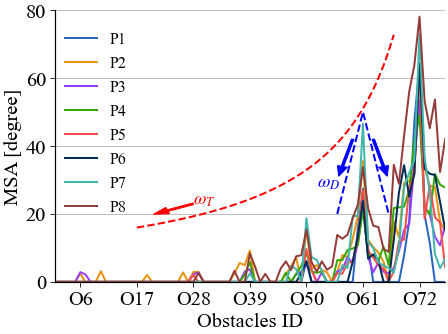

In [11]:
obj_data_raw = data['obj_data_raw']
_x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
for i in range(8):
    # plt.figure()
    # plt.xticks(np.arange(6,73, 11), _x_ticks_label)
    x = np.array(obj_data_raw[i])
    x[x<2]=0
    plt.plot(np.arange(1, 78, 1), x, label='P'+str(i+1))
plt.ylim(0,80)
plt.ylabel('MSA [degree]')
plt.xlim(1,77)
plt.xticks(np.arange(6,73, 11), _x_ticks_label)
plt.xlabel('Obstacles ID')
# plt.yticks(np.arange(0, 81, 10))
plt.legend(loc=[0.01,0.22])

plt.plot(np.arange(17, 68), 1600 / np.linspace(22, 100, 51)[::-1], linestyle='--', c='red')
a1 = plt.arrow(28, 23, -5, -2, width=0.5,head_width=2, fc='red', ec='red', zorder=100)
plt.text(28, 23, '$\omega_T$', fontsize=18, color='red')
plt.plot([56, 61, 66], [20, 50, 20], linestyle='--', c='blue')
plt.arrow(59, 42, -2, -8, width=0.5,head_width=2, fc='blue', ec='blue', zorder=100)
a2 = plt.arrow(63, 42, 2, -8, width=0.5,head_width=2, fc='blue', ec='blue', zorder=100)
plt.text(52, 28, '$\omega_D$', fontsize=18, color='blue')

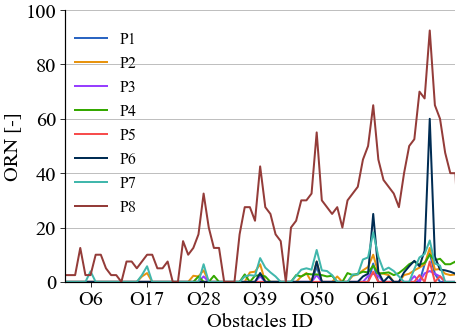

In [8]:
# plt.figure(figsize=(13,5))
fszz = 6
obj_data_raw = data['sub_data_raw']
_x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
for i in range(8):
    # plt.figure()
    # plt.xticks(np.arange(6,73, 11), _x_ticks_label)
    x = np.array(obj_data_raw[i])
    x[x<2]=0
    plt.plot(np.arange(1, 79, 1), x, label='P'+str(i+1))
plt.ylim(0,100)
plt.ylabel('ORN [-]') # , fontsize=fszz*2.54
plt.xlim(1,77)
plt.xticks(np.arange(6,73, 11), _x_ticks_label)  # , fontsize=fszz*2.54
plt.xlabel('Obstacles ID')  # , fontsize=fszz*2.54
plt.yticks(np.arange(0, 101, 20))  # , fontsize=fszz*2.54
plt.legend(loc=[0.01,0.22])  # , fontsize=fszz*2.54


maximum MSAs and ORNs of eight drivers

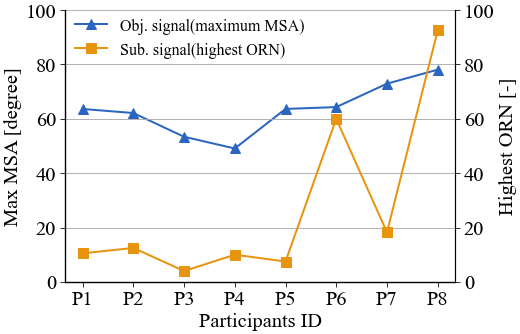

In [74]:
max_values = data['max_values']
b1, = plt.plot(np.arange(1,9), max_values[0], label='Obj. signal(maximum MSA)', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], marker='^', ms=10)
plt.ylim(0,100)
plt.ylabel('Max MSA [degree]')
_x_ticks_label = ["P{}".format(i+1) for i in range(8)]
plt.xticks(np.arange(1,9), _x_ticks_label)
plt.xlabel('Participants ID')
plt.twinx()
b2, = plt.plot(np.arange(1,9), max_values[1], label='Sub. signal(highest ORN)', c=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], marker='s', ms=10)
plt.ylim(0,100)
plt.ylabel('Highest ORN [-]')
plt.gca().spines['right'].set_visible(True)
plt.legend([b1, b2], [b1.get_label(), b2.get_label()], loc=[0.01,0.8])

#### 3.2 fitness (Figure 4)

objecitve signals

In [20]:
obj_r2 = [0.91226787, 0.93462986, 0.93824865, 0.91447483, 0.9222657, 0.9323574,  0.9305863,  0.97199417]
obj_r2_mean = 0.9321031
peak_num_angle_25 = [3, 7, 5, 4, 3, 3, 4, 5]
xx = [72,61,50,39,28,17,6]
obj_scale_list = [1.6150935888290405, 1.195246934890747, 1.2262033224105835, 1.016636848449707, 1.380411148071289, 1.7806282043457031, 1.4584137201309204, 1.7567945718765259]

In [18]:
data_coll_obj = []
type = 'obj'
for subID in range(8):
    goa = 'angle' if type=='obj' else 'response'
    net = torch.load(r'trainning results\{}_{}.pt'.format(goa, subID))
    with open(r'data\dataset.pkl', 'rb') as f:
        data_net = pickle.load(f)[subID]
    delta_v, abs_v, t_cur, d_cur, label = calibration_net.co_fn(data_net, type=type)
    net_risk = net(delta_v, abs_v, t_cur, d_cur)
    data_coll_obj.append((net_risk, label))

d:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


Text(0.42, 0.3, 'Average R$^2$=0.93')

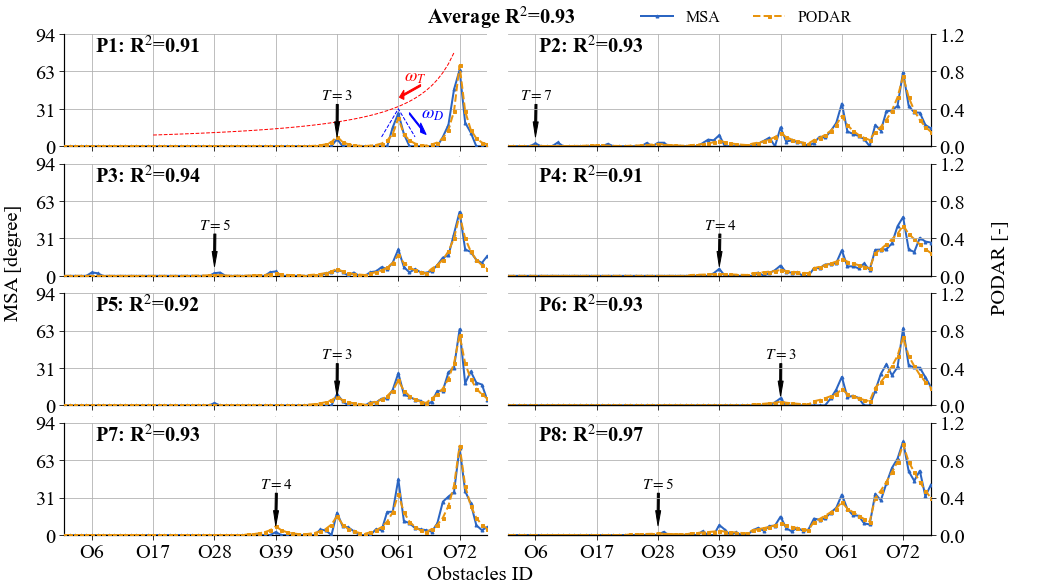

In [21]:
pos = [[0.06, 0.755, 0.42, 0.195],
       [0.50, 0.755, 0.42, 0.195],
       [0.06, 0.53, 0.42, 0.195],
       [0.50, 0.53, 0.42, 0.195],
       [0.06, 0.305, 0.42, 0.195],
       [0.50, 0.305, 0.42, 0.195],
       [0.06, 0.08, 0.42, 0.195],
       [0.50, 0.08, 0.42, 0.195]]

def plot_one(subID, label, net_risk): 
    plt.axes(pos[subID]) 
    plt.plot(np.arange(1, 78, 1), label, label='MSA', zorder=100, marker='^', ms='3')
    plt.plot(np.arange(1, 78, 1), net_risk.detach().numpy(), label='PODAR', linestyle='--', zorder=100, marker='s', ms='3')
    # plt.arrow(xx[peak_num_angle_25[subID]-1], 0.5, 0, -0.4, length_includes_head = True,head_width = 1,head_length = 0.15, width=0.25, fc='red', ec='red', zorder=100)
    # plt.text(xx[peak_num_angle_25[subID]-1]-2, 0.55, '$T=${}'.format(peak_num_angle_25[subID]))
    # plt.arrow(72-5, label[72], 5, 0, length_includes_head = True,head_width = 0.1,head_length = 2, width=0.05, fc='red', ec='red', zorder=100)
    # plt.text(xx[peak_num_angle_25[subID]-1]-2, 0.55, '$k=${}'.format(peak_num_angle_25[subID]))
    plt.annotate('$T=${}'.format(peak_num_angle_25[subID]), xy=(xx[peak_num_angle_25[subID]-1], 0.1), xytext=(xx[peak_num_angle_25[subID]-1]-2.8, 0.5), 
                arrowprops=dict(fc='black', ec='black', headwidth = 5,headlength = 15, width=2), fontsize=6*2.54, zorder=100,)
    # plt.annotate('$k=${:.3f}'.format(obj_scale_list[subID]), xy=(71, label[71]), xytext=(54, label[71]+0.02), 
    #             arrowprops=dict(fc='red', ec='red', headwidth = 5,headlength = 15, width=2), fontsize=6*2.54, zorder=100,)
    plt.xlim(1,77)
    plt.gca().grid(axis='x')
    if subID in [6, 7]:
        # plt.ylabel('Normalized MSA and PODAR [-]')    
        # plt.xlabel('Obstacles ID')
        _x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
        plt.xticks(np.arange(6,73, 11), _x_ticks_label)
    else:
        plt.xticks(np.arange(6,73, 11), fontsize=0)
    
    plt.ylim(0, 1.2)
    if subID == 0:
        plt.plot(np.arange(17, 72), 12/ np.linspace(12, 100, 55)[::-1], linestyle='--', c='red', linewidth=1)
        plt.arrow(65, 0.65, -3, -0.1, width=0.02, head_width=0.1, head_length = 0.8, fc='red', ec='red', zorder=100)
        plt.text(62, 0.7, '$\omega_T$', fontsize=18, color='red')
        plt.plot([58, 61, 64], [0.1, 0.4, 0.1], linestyle='--', c='blue', linewidth=1)
        plt.arrow(63, 0.35, 2, -0.15, width=0.02, head_width=0.1, head_length=1, fc='blue', ec='blue', zorder=100)        
        plt.text(65, 0.3, '$\omega_D$', fontsize=18, color='blue')
    if subID == 1:
        plt.legend(loc=(0.3, 1.02), ncol=2)        
    if subID % 2 == 0:
        plt.yticks(np.arange(0, 1.3, 0.4), ['{:.0f}'.format(x) for x in np.arange(0, 1.3, 0.4) * 78.8 // 1])
    else:
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(True)
        plt.yticks([])  # np.arange(0, 1.3, 0.4), fontsize=0
        plt.twinx()
        plt.gca().spines['left'].set_visible(False)
        plt.yticks(np.arange(0, 1.3, 0.4))
    plt.text(6.5, 1, 'P{}: R$^2$={:.2f}'.format(subID + 1, obj_r2[subID]), fontsize=8*2.54, fontweight='bold') 

type = 'obj'
plt.figure(figsize=(14, 8))
for subID in range(8):
    net_risk, label = data_coll_obj[subID]    
    plot_one(subID, label, net_risk)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.2)

plt.axes([0.0, 0.0, 0.05, 1]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0,0.46, 'MSA [degree]', fontsize=8*2.54, rotation=90)

plt.axes([0.98, 0.0, 0.05, 1]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0,0.47, 'PODAR [-]', fontsize=8*2.54, rotation=90)

plt.axes([0.0, 0.0, 1, 0.03]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0.42, 0.1, 'Obstacles ID', fontsize=8*2.54)

plt.axes([0.0, 0.96, 1, 0.025]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0.42, 0.3, 'Average R$^2$={:.2f}'.format(obj_r2_mean), fontsize=8*2.54, fontweight='bold')


subjectiv signals

In [22]:
sub_r2 = [0.92710129, 0.84884372, 0.70157367, 0.89792147, 0.89588728, 0.96243812,  0.86342268, 0.93466543]
sub_r2_mean = 0.87898171
peak_num_respons = [4, 7, 7, 6, 5, 4, 7, 7]
xx = [72,61,50,39,28,17,6]

In [24]:
data_coll_sub = []
type = 'sub'
for subID in range(8):
    goa = 'angle' if type=='obj' else 'response'
    net = torch.load(r'trainning results\{}_{}.pt'.format(goa, subID))
    with open(r'data\dataset.pkl', 'rb') as f:
        data_net = pickle.load(f)[subID]
    delta_v, abs_v, t_cur, d_cur, label = calibration_net.co_fn(data_net, type=type)
    net_risk = net(delta_v, abs_v, t_cur, d_cur)
    data_coll_sub.append((net_risk, label))

Text(0.42, 0.4, 'Average R$^2$=0.88')

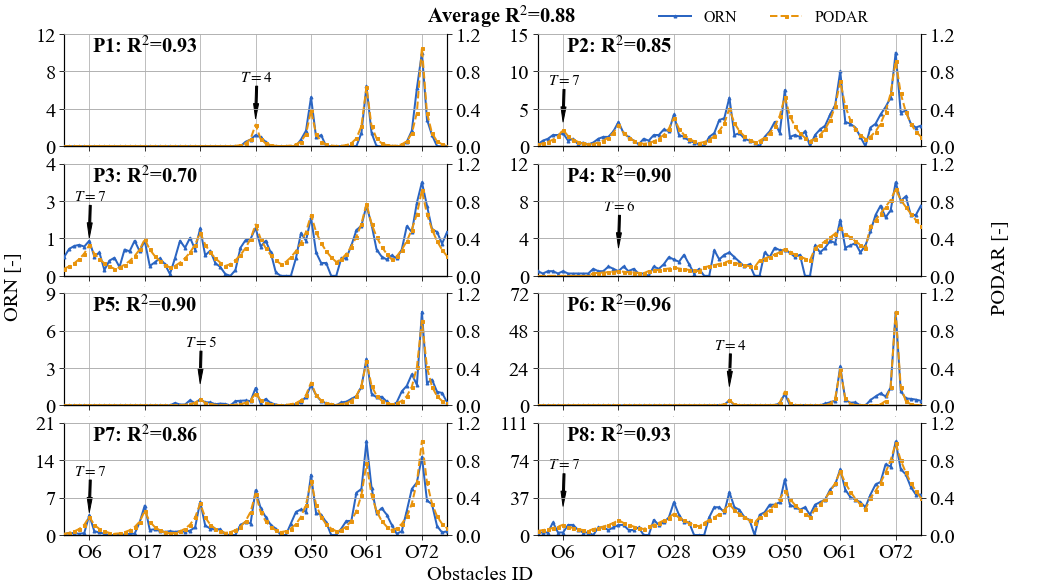

In [26]:
pos = [[0.06, 0.755, 0.38, 0.195],
       [0.53, 0.755, 0.38, 0.195],
       [0.06, 0.530, 0.38, 0.195],
       [0.53, 0.530, 0.38, 0.195],
       [0.06, 0.305, 0.38, 0.195],
       [0.53, 0.305, 0.38, 0.195],
       [0.06, 0.080, 0.38, 0.195],
       [0.53, 0.080, 0.38, 0.195]]
highest_orn = data['max_values'][1]

def plot_one(subID, label, net_risk): 
    plt.axes(pos[subID]) 
    plt.plot(np.arange(1, 78, 1), label, label='ORN', zorder=100, marker='^', ms='3')
    plt.plot(np.arange(1, 78, 1), net_risk.detach().numpy(), label='PODAR', linestyle='--', zorder=100, marker='s', ms='3')
    plt.annotate('$T=${}'.format(peak_num_respons[subID]), xy=(xx[peak_num_respons[subID]-1], label[xx[peak_num_respons[subID]-1]]+0.2), xytext=(xx[peak_num_respons[subID]-1]-3, label[xx[peak_num_respons[subID]-1]]+0.6), 
                arrowprops=dict(fc='black', ec='black', headwidth = 5,headlength = 15, width=2), fontsize=6*2.54, zorder=100,)
    plt.xlim(1,77)
    plt.gca().grid(axis='x')
    if subID in [6, 7]:
        # plt.ylabel('Normalized MSA and PODAR [-]')    
        # plt.xlabel('Obstacles ID')
        _x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
        plt.xticks(np.arange(6,73, 11), _x_ticks_label)
    else:
        plt.xticks(np.arange(6,73, 11), fontsize=0)    
    
    plt.ylim(0, 1)
    if subID == 1:
        plt.legend(loc=(0.3, 1.02), ncol=2)
    plt.yticks(np.arange(0, 1.3, 0.4), ['{:.0f}'.format(x) for x in np.arange(0, 1.3, 0.4) * highest_orn[subID] // 1])
    plt.yticks(np.arange(0, 1.3, 0.4), ['{:.0f}'.format(x) for x in np.arange(0, 1.3, 0.4) * highest_orn[subID] // 1])
    plt.gca().spines['right'].set_visible(True)
    plt.twinx()
    plt.gca().spines['left'].set_visible(False)
    plt.yticks(np.arange(0, 1.3, 0.4))
    plt.text(6.5, 1, 'P{}: R$^2$={:.2f}'.format(subID + 1, sub_r2[subID]), fontsize=8*2.54, fontweight='bold') 

type = 'obj'
plt.figure(figsize=(14, 8))
for subID in range(8):
    net_risk, label = data_coll_sub[subID]    
    plot_one(subID, label, net_risk)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.2)

plt.axes([0.0, 0.0, 0.05, 1]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0,0.46, 'ORN [-]', fontsize=8*2.54, rotation=90)

plt.axes([0.98, 0.0, 0.05, 1]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0,0.47, 'PODAR [-]', fontsize=8*2.54, rotation=90)

plt.axes([0.0, 0.0, 1, 0.03]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0.42, 0.1, 'Obstacles ID', fontsize=8*2.54)

plt.axes([0.0, 0.96, 1, 0.025]) 
plt.grid('off')
plt.yticks([])
plt.xticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.text(0.42, 0.4, 'Average R$^2$={:.2f}'.format(sub_r2_mean), fontsize=8*2.54, fontweight='bold')

In [12]:
peak_num_angle_25 = [3, 7, 5, 4, 3, 3, 4, 5]
peak_num_respons = [4, 7, 7, 6, 5, 4, 7, 7]
mean_angle_ph = np.mean(peak_num_angle_25)
mean_resp_ph = np.mean(peak_num_respons)
print(mean_angle_ph)
print(mean_resp_ph)

4.25
5.875


#### 3.3 prediction horizons (Figure 5)

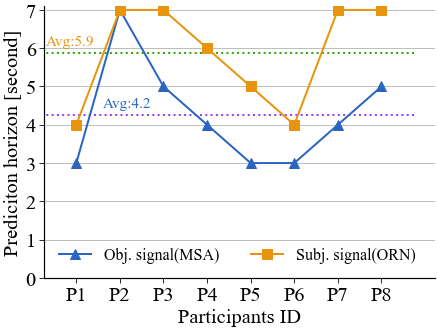

In [27]:
plt.plot(np.arange(1,9), peak_num_angle_25, label='Obj. signal(MSA)', zorder=100, marker='^', ms=10)
plt.plot(np.arange(1,9), peak_num_respons, label='Subj. signal(ORN)', zorder=100, marker='s', ms=10)

plt.plot([0.2,8.8], [mean_angle_ph, mean_angle_ph], linestyle=':')
plt.plot([0.2,8.8], [mean_resp_ph, mean_resp_ph], linestyle=':')

plt.text(1.6, mean_angle_ph + 0.2, 'Avg:{:.1f}'.format(mean_angle_ph), c=color_map1[0], fontsize=6*2.54)
plt.text(0.3, mean_resp_ph + 0.2, 'Avg:{:.1f}'.format(mean_resp_ph), c=color_map1[1], fontsize=6*2.54)

_x_ticks_label = ["P{}".format(i+1) for i in range(8)]
plt.xticks(np.arange(1,9), _x_ticks_label)
plt.xlim(0.27)
plt.ylim(0,7.1)
plt.ylabel('Prediciton horizon [second]')
plt.yticks(np.arange(0,8))
plt.xlabel('Participants ID')
plt.legend(ncol=2)  # , loc=[0.05,0.9]

#### 3.4 scales (Figure 6)

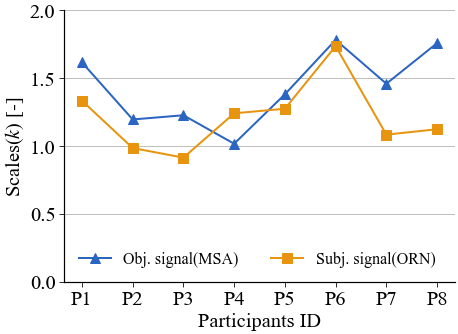

In [28]:
obj_scale_list = [1.6150935888290405, 1.195246934890747, 1.2262033224105835, 1.016636848449707, 1.380411148071289, 1.7806282043457031, 1.4584137201309204, 1.7567945718765259]
sub_scale_list = [1.33290433883667, 0.985039472579956, 0.9143654108047485, 1.2405551671981812, 1.274121880531311, 1.7350612878799438, 1.0835251808166504, 1.1234524250030518]

plt.plot(np.arange(1,9), obj_scale_list, label='Obj. signal(MSA)', zorder=100 , marker='^', ms=10)
plt.plot(np.arange(1,9), sub_scale_list, label='Subj. signal(ORN)', zorder=100, marker='s', ms=10)

_x_ticks_label = ["P{}".format(i+1) for i in range(8)]
plt.xticks(np.arange(1,9), _x_ticks_label)
plt.ylim(0,2)
plt.ylabel('Scales($k$) [-]')
plt.yticks(np.linspace(0,2, 5))
plt.xlabel('Participants ID')
plt.legend(ncol=2)  #, loc=[0.05,0.9]

#### 3.4 Objective signals (Figure 7)

Figure 7ac

objective signals: 

temporal and spatial attenuation: A and B influences

0.9191919191919191


Text(0.5, 0, 'Relative distance [m]')

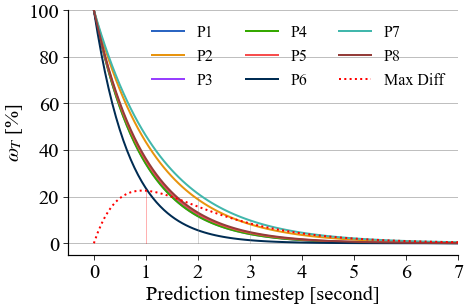

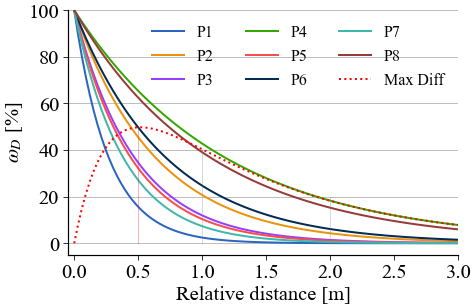

In [29]:
A_list = [1.0600444078445435, 0.8356727361679077, 1.0756944417953491, 1.0794345140457153, 1.036150336265564, 1.4461475610733032, 0.7743525505065918, 1.0152881145477295]
B_list = [3.715822219848633, 1.576579213142395, 2.126253843307495, 0.8500350117683411, 2.26875638961792, 1.3990570306777954, 2.6167290210723877, 0.9408774971961975]
podar_max = [0.865146815776825, 0.7491351366043091, 0.6496762037277222, 0.5372337698936462, 0.7519077658653259, 0.7279267907142639, 0.9541683197021484, 0.9710002541542053]
scale_list = [1.6150935888290405, 1.195246934890747, 1.2262033224105835, 1.016636848449707, 1.380411148071289, 1.7806282043457031, 1.4584137201309204, 1.7567945718765259]
Alpha_list = [0.7] * 8
horizon_list = [4, 7, 7, 6, 5, 4, 7, 7]

plt.figure(figsize=(7,4.5))
x = np.linspace(0,7,100)
for i in range(8):
    plt.plot(x, np.exp(-1 * x * A_list[i]) * 100, label='P{}'.format(i+1))  #label='P{}: $A$={:.3f}'.format(i+1, A_list[i])

tmp7 = np.exp(-1 * x * A_list[6]) * 100
tmp6 = np.exp(-1 * x * A_list[5]) * 100
plt.plot(x, tmp7 - tmp6, c='red', linestyle=':', label='Max Diff')
print(x[np.argmax(tmp7 - tmp6)])

plt.plot([1,1], [0, 22], c='red', linestyle='-', alpha=0.3, lw=1)

plt.plot([2,2], [0, 20], c='gray', linestyle='-', alpha=0.3, lw=1)
plt.plot([3,3], [0, 10], c='gray', linestyle='-', alpha=0.3, lw=1)

plt.xlim(-0.5,7)
plt.xticks(np.linspace(0, 7,8))
plt.ylim(-5,100)
plt.legend(ncol=3)
plt.ylabel('$\omega_T$ [%]')
plt.xlabel('Prediction timestep [second]')


plt.figure(figsize=(7,4.5))
x = np.linspace(0,3,100)
for i in range(8):
    plt.plot(x, np.exp(-1 * x * B_list[i]) * 100, label='P{}'.format(i+1))  # label='P{}: $B$={:.3f}'.format(i+1, B_list[i])

tmp0 = np.exp(-1 * x * B_list[0]) * 100
tmp3 = np.exp(-1 * x * B_list[3]) * 100
plt.plot(x, tmp3 - tmp0, c='red', linestyle=':', label='Max Diff')

plt.plot([0.5,0.5], [0, 50], c='red', linestyle='-', alpha=0.3, lw=1)

plt.plot([1,1], [0, 40], c='gray', linestyle='-', alpha=0.3, lw=1)
plt.plot([2,2], [0, 20], c='gray', linestyle='-', alpha=0.3, lw=1)

plt.xlim(-0.05,3)
plt.xticks(np.linspace(0, 3, 7))
plt.ylim(-5,100)
plt.legend(ncol=3)
plt.ylabel('$\omega_D$ [%]')
plt.xlabel('Relative distance [m]')


Figure 7bd

subjective signals: 

temporal and spatial attenuation: A and B influences

2.191919191919192
0.3939393939393939


Text(0.5, 0, 'Relative distance [m]')

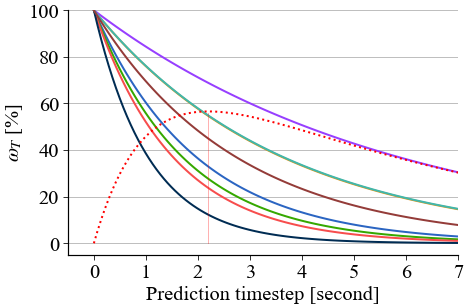

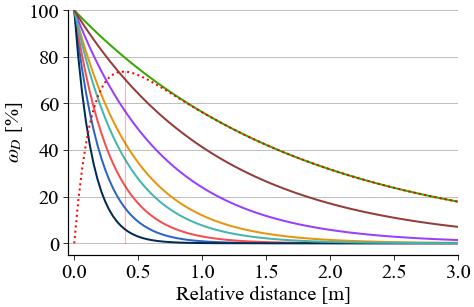

In [30]:
A_list = [0.5059422850608826, 0.27508944272994995, 0.17000000178813934, 0.5848498940467834, 0.654693603515625, 0.9557044506072998, 0.27345994114875793, 0.3641781210899353]
B_list = [4.764817714691162, 2.1246397495269775, 1.4296964406967163, 0.5749660134315491, 3.5374858379364014, 7.115493297576904, 2.573143720626831, 0.8856412768363953]
podar_max = [1.0523048639297485, 0.9140646457672119, 0.9132525324821472, 0.9267663955688477, 0.9064257740974426, 0.9998318552970886, 1.0066016912460327, 0.9794774651527405]
scale_list = [1.33290433883667, 0.985039472579956, 0.9143654108047485, 1.2405551671981812, 1.274121880531311, 1.7350612878799438, 1.0835251808166504, 1.1234524250030518]
Alpha_list = [0.7] * 8
horizon_list = [4, 7, 7, 6, 5, 4, 7, 7]


plt.figure(figsize=(7,4.5))
x = np.linspace(0,7,100)
for i in range(8):
    plt.plot(x, np.exp(-1 * x * A_list[i]) * 100, label='P{}'.format(i+1))  # label='P{}: $A$={:.3f}'.format(i+1, A_list[i])

tmp3 = np.exp(-1 * x * A_list[2]) * 100
tmp6 = np.exp(-1 * x * A_list[5]) * 100
plt.plot(x, tmp3 - tmp6, c='red', linestyle=':', label='Max Diff')
print(x[np.argmax(tmp3 - tmp6)])


plt.plot([2.2,2.2], [0, 56], c='red', linestyle='-', alpha=0.3, lw=1)

plt.xlim(-0.5,7)
plt.xticks(np.linspace(0, 7,8))
plt.ylim(-5,100)
# plt.legend(ncol=3)
plt.ylabel('$\omega_T$ [%]')
plt.xlabel('Prediction timestep [second]')
# plt.savefig(r'E:\博后工作资料\01_研究工作\06_论文\03_PODAR_carlibration\PODAR_carlibration_clear_NC_template_clear\images\fig012_sub_A.pdf', bbox_inches='tight')  # , bbox_inches='tight'

plt.figure(figsize=(7,4.5))
x = np.linspace(0,3,100)
for i in range(8):
    plt.plot(x, np.exp(-1 * x * B_list[i]) * 100, label='P{}'.format(i+1))

tmp4 = np.exp(-1 * x * B_list[3]) * 100
tmp6 = np.exp(-1 * x * B_list[5]) * 100
plt.plot(x, tmp4 - tmp6, c='red', linestyle=':', label='Max Diff')
print(x[np.argmax(tmp4 - tmp6)])

plt.plot([0.4,0.4], [0, 74], c='red', linestyle='-', alpha=0.3, lw=1)

plt.xlim(-0.05,3)
plt.xticks(np.linspace(0, 3, 7))
plt.ylim(-5,100)
# plt.legend(ncol=3)
plt.ylabel('$\omega_D$ [%]')
plt.xlabel('Relative distance [m]')
# plt.savefig(r'E:\博后工作资料\01_研究工作\06_论文\03_PODAR_carlibration\PODAR_carlibration_clear_NC_template_clear\images\fig13_sub_B.pdf', bbox_inches='tight')  # , bbox_inches='tight'

Figure 7ef

Obj vs Sub

In [31]:
obj_A_list = [1.0600444078445435, 0.8356727361679077, 1.0756944417953491, 1.0794345140457153, 1.036150336265564, 1.4461475610733032, 0.7743525505065918, 1.0152881145477295]
obj_B_list = [3.715822219848633, 1.576579213142395, 2.126253843307495, 0.8500350117683411, 2.26875638961792, 1.3990570306777954, 2.6167290210723877, 0.9408774971961975]
sub_A_list = [0.5059422850608826, 0.27508944272994995, 0.17000000178813934, 0.5848498940467834, 0.654693603515625, 0.9557044506072998, 0.27345994114875793, 0.3641781210899353]
sub_B_list = [4.764817714691162, 2.1246397495269775, 1.4296964406967163, 0.5749660134315491, 3.5374858379364014, 7.115493297576904, 2.573143720626831, 0.8856412768363953]

Text(0, 0.5, '$B_{\\mathrm{sub}}$')

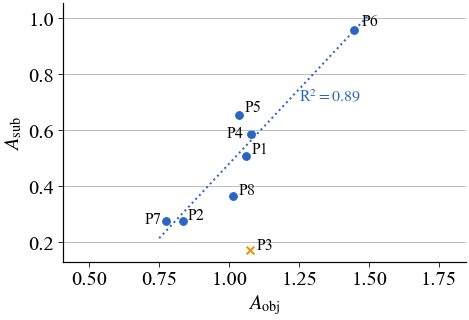

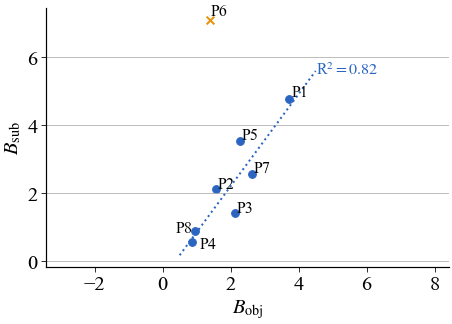

In [32]:
plt.figure(figsize=(7,4.5))
# plt.axes([0.125,0.14, 0.82,0.74 / 0.85*0.82])
plt.axes([0.14,0.14, 0.8, 0.8])
for i in range(8):
    plt.scatter(obj_A_list[i], sub_A_list[i], c=color_map1[0] if i!=2 else color_map1[1], marker='o' if i!=2 else 'x', s=60)
    if i == 3: 
        x, y = obj_A_list[i]*0.92, sub_A_list[i]*0.98
    elif i == 6: 
        x, y = obj_A_list[i]*0.90, sub_A_list[i]*0.98
    else:
        x, y = obj_A_list[i]*1.02, sub_A_list[i]*1.02
    plt.text(x, y, 'P{}'.format(i+1), fontsize=16)
plt.plot([0.75, 1.5], [1.0653*0.75-0.586, 1.0653*1.5-0.586], linestyle=':')
plt.text(1.25,0.7, 'R$^2=0.89$', fontsize=16, c=color_map1[0])
plt.axis('equal')
# plt.xlim(0,1.5)
# plt.ylim(0,1.5 /7*5)
plt.xlabel('$A_{\mathrm{obj}}$')
plt.ylabel('$A_{\mathrm{sub}}$')
plt.savefig(r'E:\博后工作资料\01_研究工作\06_论文\03_PODAR_carlibration\PODAR_carlibration_clear_NC_template_clear\images\fig014_A_vs.pdf', bbox_inches='tight')  # , bbox_inches='tight'

plt.figure(figsize=(7,4.5))
# plt.axes([0.125,0.14, 0.85/0.86*0.83,0.83]) 
plt.axes([0.14, 0.14, 0.8, 0.8])
for i in range(8):
    plt.scatter(obj_B_list[i], sub_B_list[i], c=color_map1[0] if i!=5 else color_map1[1], marker='o' if i!=5 else 'x', s=60)
    if i == 7: 
        x, y = obj_B_list[i]*0.4, sub_B_list[i]*0.98
    elif i == 3: 
        x, y = obj_B_list[i]*1.3, sub_B_list[i]*0.7
    else:
        x, y = obj_B_list[i]*1.02, sub_B_list[i]*1.02
    plt.text(x, y, 'P{}'.format(i+1), fontsize=16)
plt.plot([0.5, 4.5], [1.3553*0.5-0.495, 1.3553*4.5-0.495], linestyle=':')
plt.text(4.5, 5.5, 'R$^2=0.82$', fontsize=16, c=color_map1[0])
# plt.xlim(0,8)
plt.axis('equal')
# plt.ylim(0,8.0)
plt.xlabel('$B_{\mathrm{obj}}$')
plt.ylabel('$B_{\mathrm{sub}}$')
